In [1]:
import os

MAT_ROOT = "/content/drive/MyDrive/figshare/dataset/data"

YOLO_ROOT_MC = "/content/figshare_yolo_multi"
IMG_ALL_DIR   = os.path.join(YOLO_ROOT_MC, "images_all")
LABEL_ALL_DIR = os.path.join(YOLO_ROOT_MC, "labels_all")

os.makedirs(IMG_ALL_DIR, exist_ok=True)
os.makedirs(LABEL_ALL_DIR, exist_ok=True)

print("MAT_ROOT:", MAT_ROOT)
print("YOLO_ROOT_MC:", YOLO_ROOT_MC)


MAT_ROOT: /content/drive/MyDrive/figshare/dataset/data
YOLO_ROOT_MC: /content/figshare_yolo_multi


In [2]:
import h5py
import numpy as np

def load_mat_v7_3(path):
    with h5py.File(path, 'r') as f:
        cj = f['cjdata']
        image = np.array(cj['image']).T
        mask  = np.array(cj['tumorMask']).T
        label = int(np.array(cj['label'])[0][0])
    return image, mask, label


In [3]:
test_path = os.path.join(MAT_ROOT, os.listdir(MAT_ROOT)[0])
img, msk, lab = load_mat_v7_3(test_path)
print(img.shape, msk.shape, lab)


(512, 512) (512, 512) 2


In [4]:
# Figshare label
label_to_class_id = {
    1: 0,   # glioma
    2: 1,   # meningioma
    3: 2    # pituitary
}


In [5]:
import cv2
from tqdm import tqdm
from scipy.ndimage import label as cc_label

mat_files = [f for f in os.listdir(MAT_ROOT) if f.endswith(".mat")]
print("Number of .mat files:", len(mat_files))

for fname in tqdm(mat_files):
    mat_path = os.path.join(MAT_ROOT, fname)

    image, mask, label_val = load_mat_v7_3(mat_path)
    H, W = image.shape

    if label_val not in label_to_class_id:
        continue

    class_id = label_to_class_id[label_val]

    # ---- save image ----
    base = os.path.splitext(fname)[0]
    img_path = os.path.join(IMG_ALL_DIR, base + ".jpg")

    img_uint8 = cv2.normalize(image, None, 0, 255,
                              cv2.NORM_MINMAX).astype("uint8")
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(img_path, img_rgb)

    # ---- build YOLO label from mask
    bin_mask = (mask > 0).astype(np.uint8)
    if bin_mask.sum() == 0:

        continue

    labeled, num_cc = cc_label(bin_mask)
    lines = []

    for cc_id in range(1, num_cc + 1):
        ys, xs = np.where(labeled == cc_id)
        if len(xs) == 0:
            continue
        if len(xs) < 20:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        x_center = (x_min + x_max) / 2 / W
        y_center = (y_min + y_max) / 2 / H
        bw = (x_max - x_min) / W
        bh = (y_max - y_min) / H

        lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

    if lines:
        label_path = os.path.join(LABEL_ALL_DIR, base + ".txt")
        with open(label_path, "w") as f:
            f.write("\n".join(lines))


Number of .mat files: 3064


100%|██████████| 3064/3064 [02:40<00:00, 19.08it/s]


In [6]:
import glob, shutil, random

all_images = sorted(glob.glob(os.path.join(IMG_ALL_DIR, "*.jpg")))
print("Total images:", len(all_images))

labeled_images = []
for img_path in all_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    if os.path.exists(os.path.join(LABEL_ALL_DIR, base + ".txt")):
        labeled_images.append(img_path)

print("With labels:", len(labeled_images))

random.seed(42)
random.shuffle(labeled_images)

split_idx = int(0.8 * len(labeled_images))
train_imgs = labeled_images[:split_idx]
val_imgs   = labeled_images[split_idx:]

print("Train:", len(train_imgs))
print("Val:", len(val_imgs))

def copy_split(img_list, split):
    img_out   = os.path.join(YOLO_ROOT_MC, "images", split)
    label_out = os.path.join(YOLO_ROOT_MC, "labels", split)
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(label_out, exist_ok=True)

    for img_path in img_list:
        base = os.path.splitext(os.path.basename(img_path))[0]
        shutil.copy2(img_path, os.path.join(img_out, base + ".jpg"))
        shutil.copy2(os.path.join(LABEL_ALL_DIR, base + ".txt"),
                     os.path.join(label_out, base + ".txt"))

copy_split(train_imgs, "train")
copy_split(val_imgs, "val")


Total images: 3064
With labels: 3064
Train: 2451
Val: 613


In [7]:
brain_mc_yaml = """
path: /content/figshare_yolo_multi

train: images/train
val: images/val

names:
  0: glioma
  1: meningioma
  2: pituitary
"""

import os
yaml_path = os.path.join(YOLO_ROOT_MC, "brain_mc.yaml")
with open(yaml_path, "w") as f:
    f.write(brain_mc_yaml)

print("Created:", yaml_path)


Created: /content/figshare_yolo_multi/brain_mc.yaml


In [8]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00


In [9]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/figshare_yolo_multi/brain_mc.yaml",
    epochs=50,
    imgsz=512,
    batch=8,
    patience=10,
    workers=2
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/figshare_yolo_multi/brain_mc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou

In [10]:
best_model = YOLO("runs/detect/train/weights/best.pt")


best_model.val(
    data="/content/figshare_yolo_multi/brain_mc.yaml",
    imgsz=512,
    batch=8
)


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1340.0±841.8 MB/s, size: 50.2 KB)
val: Scanning /content/figshare_yolo_multi/labels/val.cache... 613 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 613/613 1.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 77/77 8.5it/s 9.0s
                   all        613        613      0.864      0.897      0.917      0.654
                glioma        125        125      0.932       0.98      0.985      0.803
            meningioma        294        294      0.774      0.769      0.807      0.502
             pituitary        194        194      0.887      0.943      0.958      0.658
Speed: 1.4ms preprocess, 4.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b65eef6d520>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [11]:
pred = best_model.predict(
    source="/content/figshare_yolo_multi/images/val",
    imgsz=512,
    conf=0.25,
    save=True,
    project="runs/detect",
    name="mc_val_pred",
    exist_ok=True
)



image 1/613 /content/figshare_yolo_multi/images/val/10.jpg: 512x512 1 glioma, 5.6ms
image 2/613 /content/figshare_yolo_multi/images/val/100.jpg: 512x512 1 glioma, 5.8ms
image 3/613 /content/figshare_yolo_multi/images/val/1003.jpg: 512x512 1 pituitary, 6.3ms
image 4/613 /content/figshare_yolo_multi/images/val/1005.jpg: 512x512 1 pituitary, 5.6ms
image 5/613 /content/figshare_yolo_multi/images/val/101.jpg: 512x512 2 gliomas, 5.6ms
image 6/613 /content/figshare_yolo_multi/images/val/1010.jpg: 512x512 1 pituitary, 6.3ms
image 7/613 /content/figshare_yolo_multi/images/val/1018.jpg: 512x512 1 pituitary, 5.6ms
image 8/613 /content/figshare_yolo_multi/images/val/1021.jpg: 512x512 1 pituitary, 7.5ms
image 9/613 /content/figshare_yolo_multi/images/val/1024.jpg: 512x512 1 pituitary, 5.6ms
image 10/613 /content/figshare_yolo_multi/images/val/1027.jpg: 512x512 1 pituitary, 5.6ms
image 11/613 /content/figshare_yolo_multi/images/val/1032.jpg: 512x512 1 pituitary, 5.6ms
image 12/613 /content/figshare

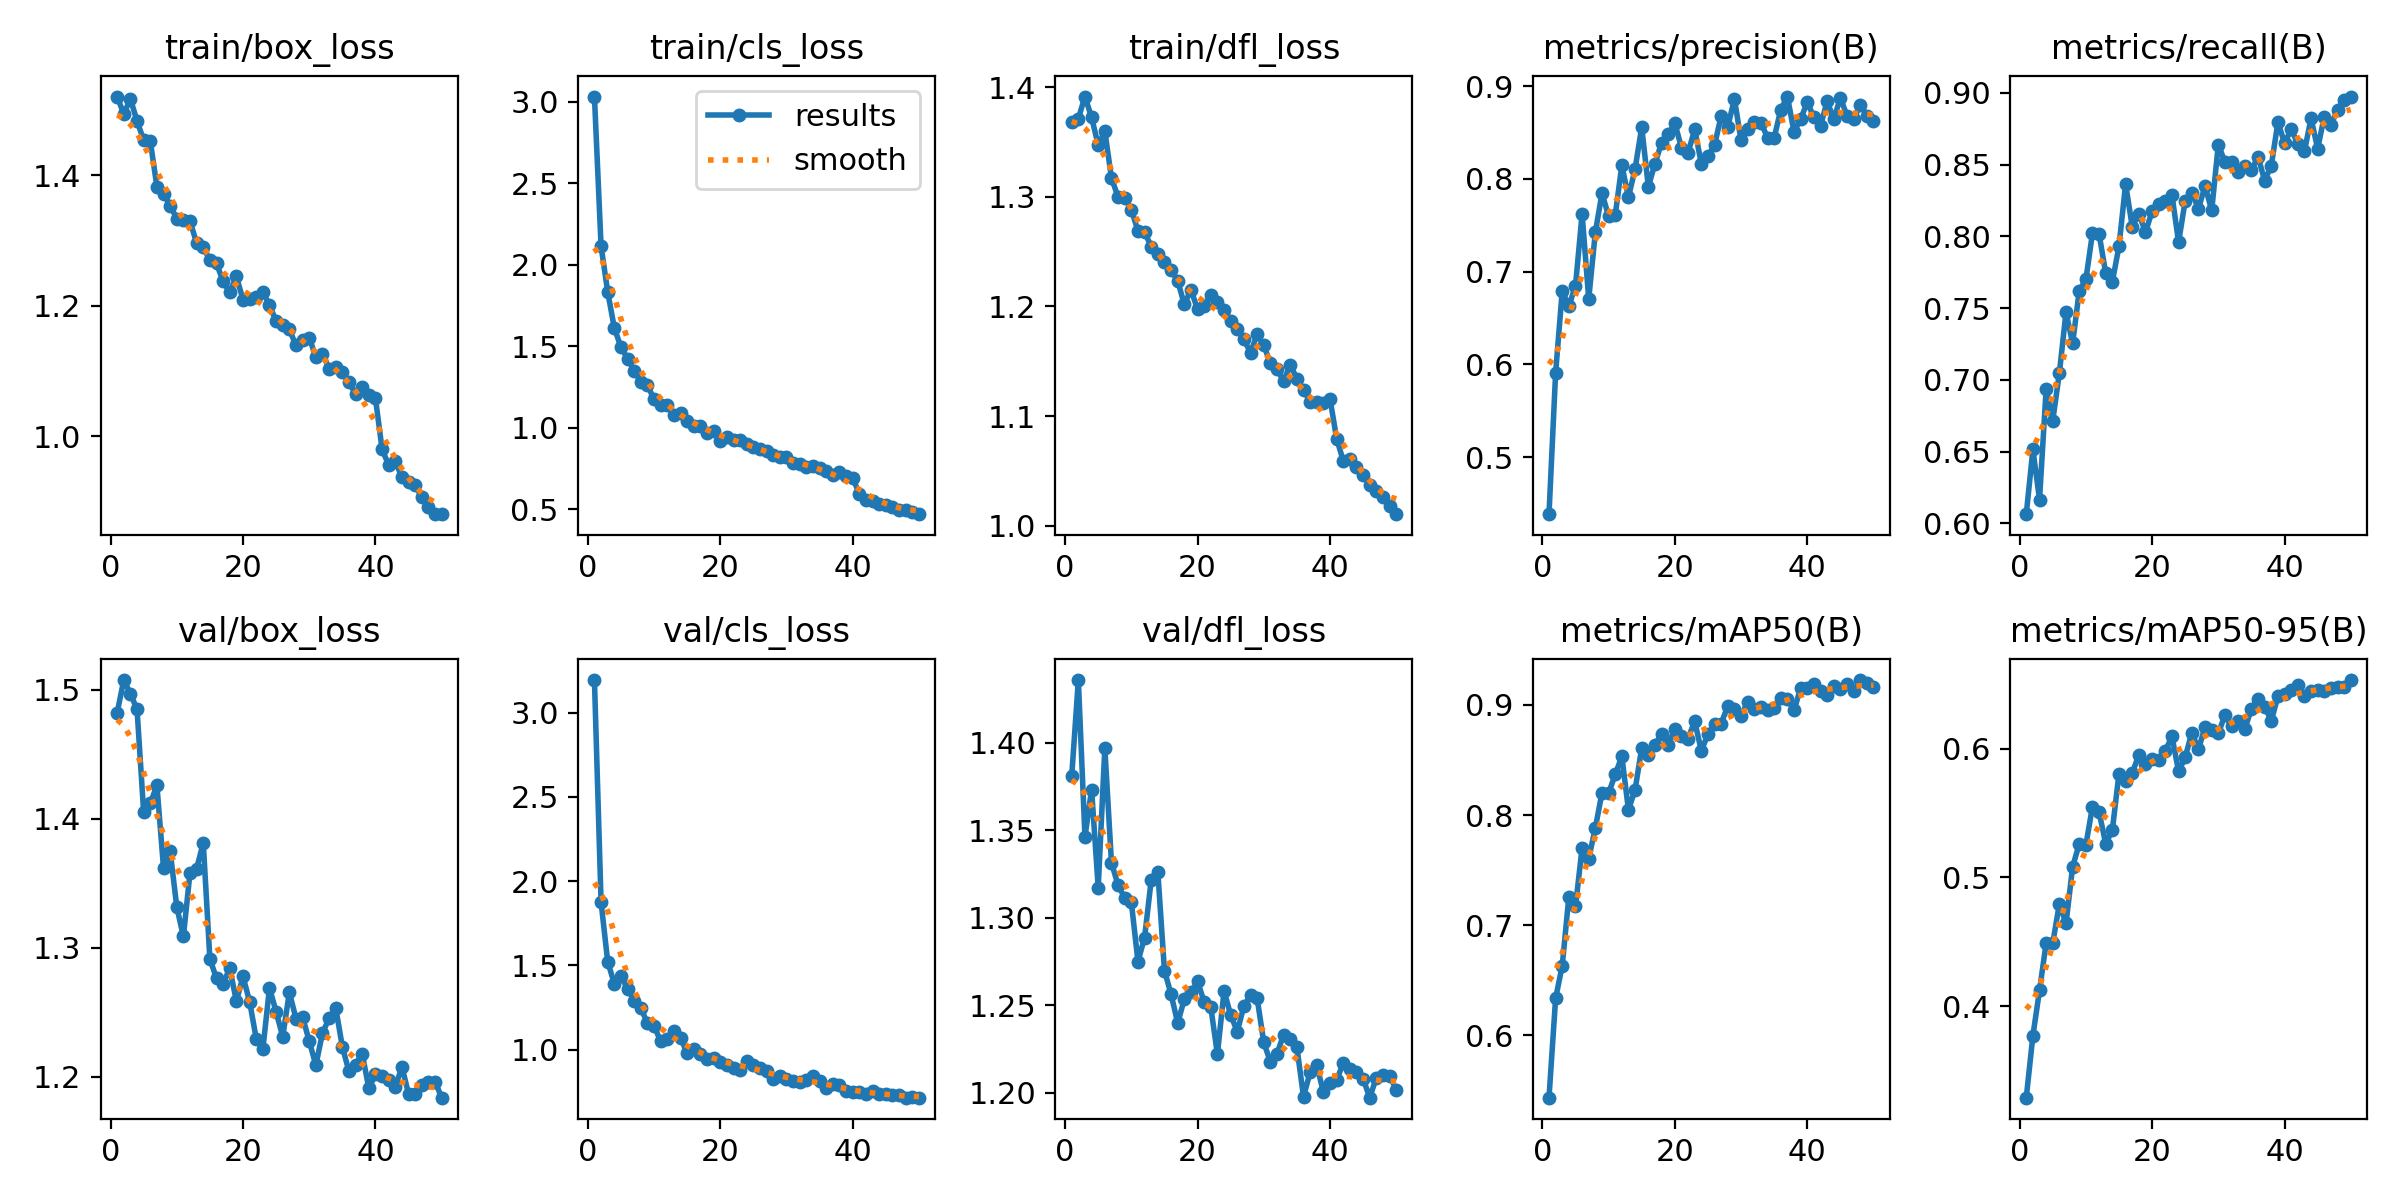

In [12]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

run_dir = "runs/detect/train"   # change if your run name is different

# Make sure the results are plotted (creates results.png if missing)
model = YOLO(os.path.join(run_dir, "weights", "last.pt"))
# The results.png file is generated during training, no need to call plot_results() here.
# model.plot_results()   # creates/updates results.png

display(Image(filename=os.path.join(run_dir, "results.png")))

['runs/detect/train/BoxF1_curve.png', 'runs/detect/train/BoxPR_curve.png', 'runs/detect/train/BoxP_curve.png', 'runs/detect/train/BoxR_curve.png', 'runs/detect/train/confusion_matrix.png', 'runs/detect/train/confusion_matrix_normalized.png', 'runs/detect/train/results.png']
BoxF1_curve.png


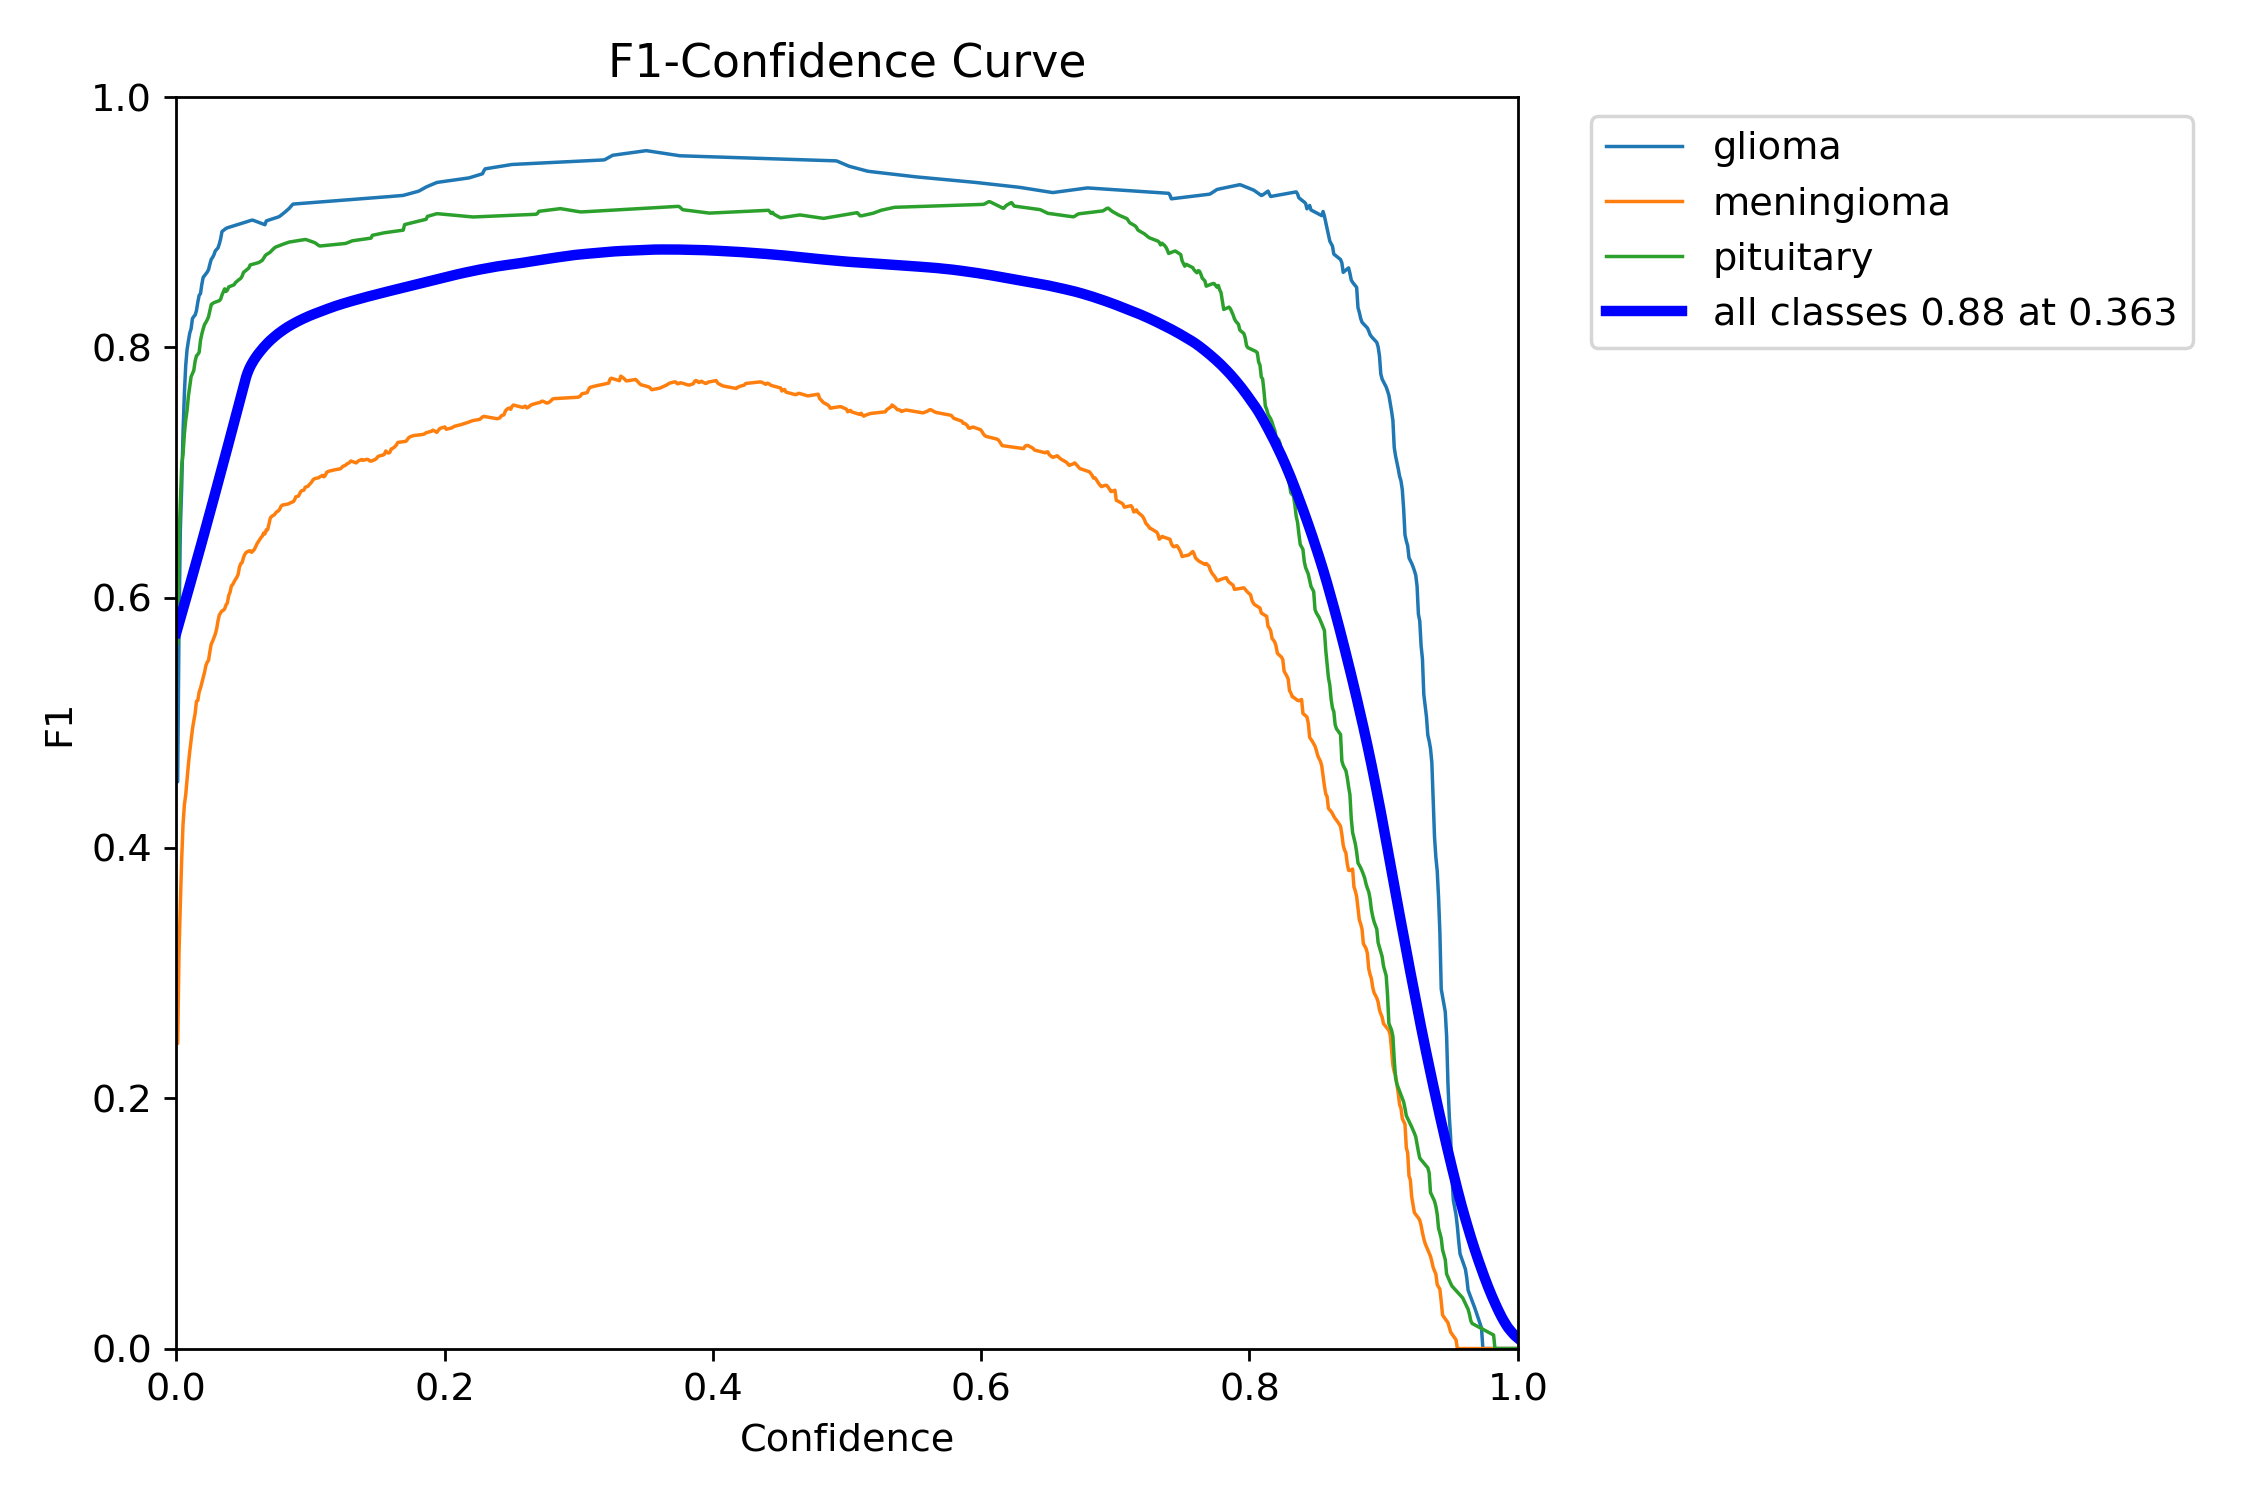

BoxPR_curve.png


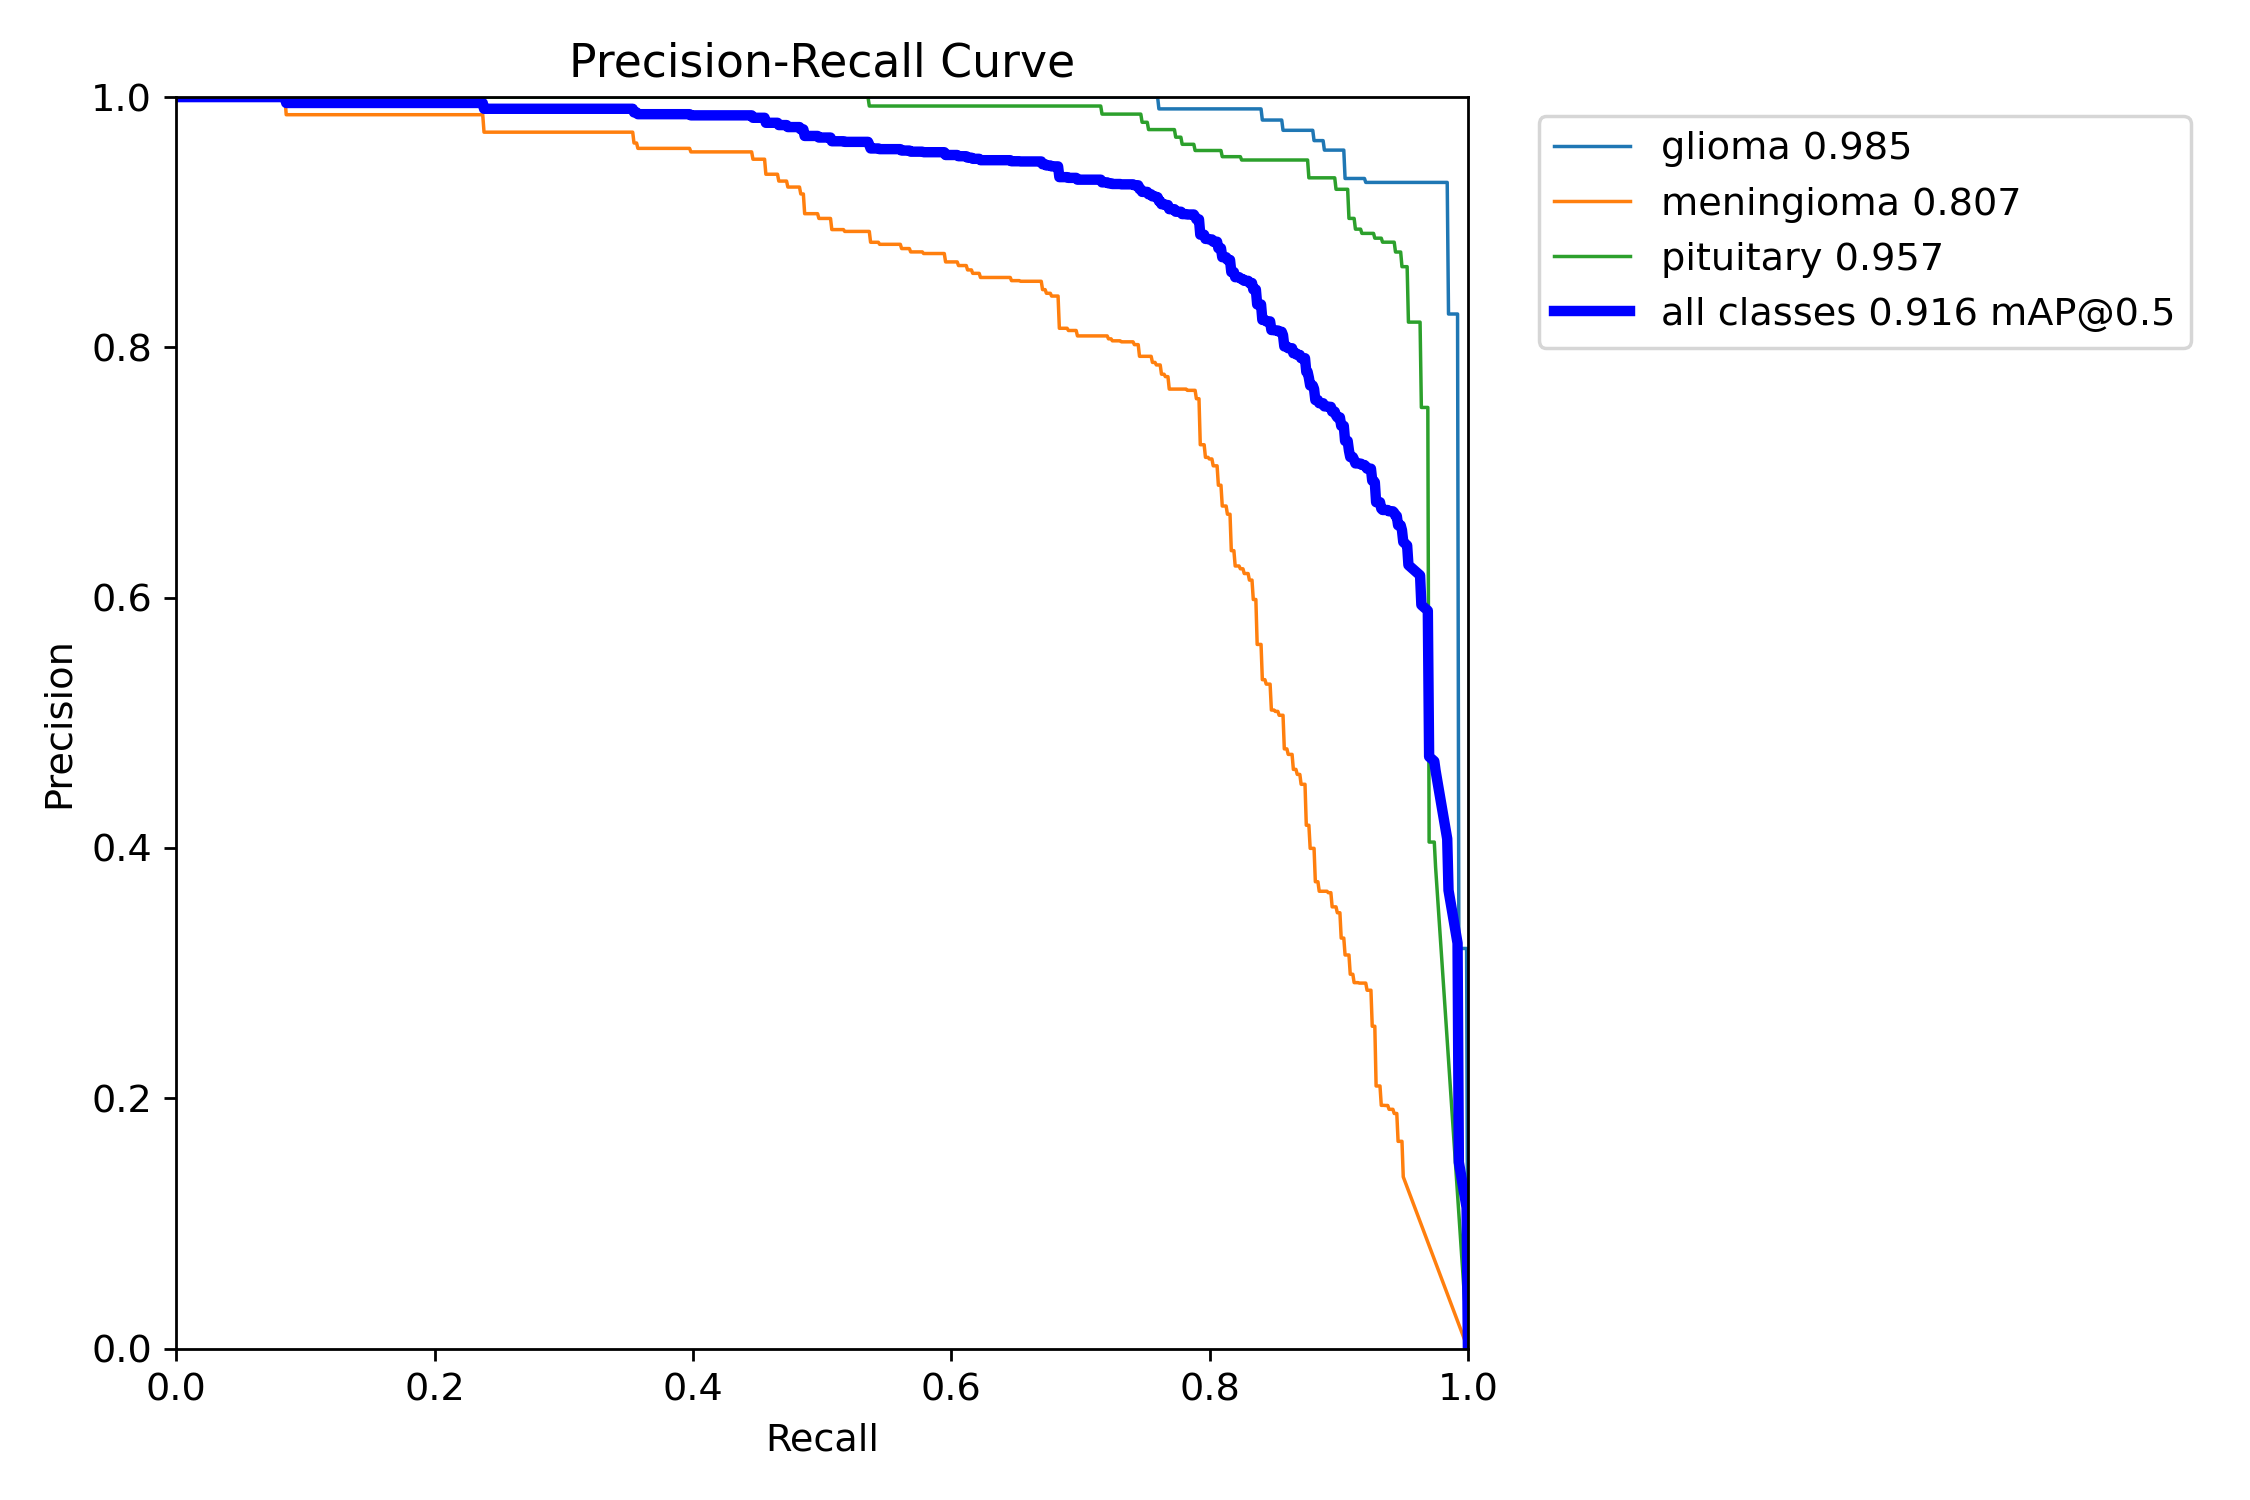

BoxP_curve.png


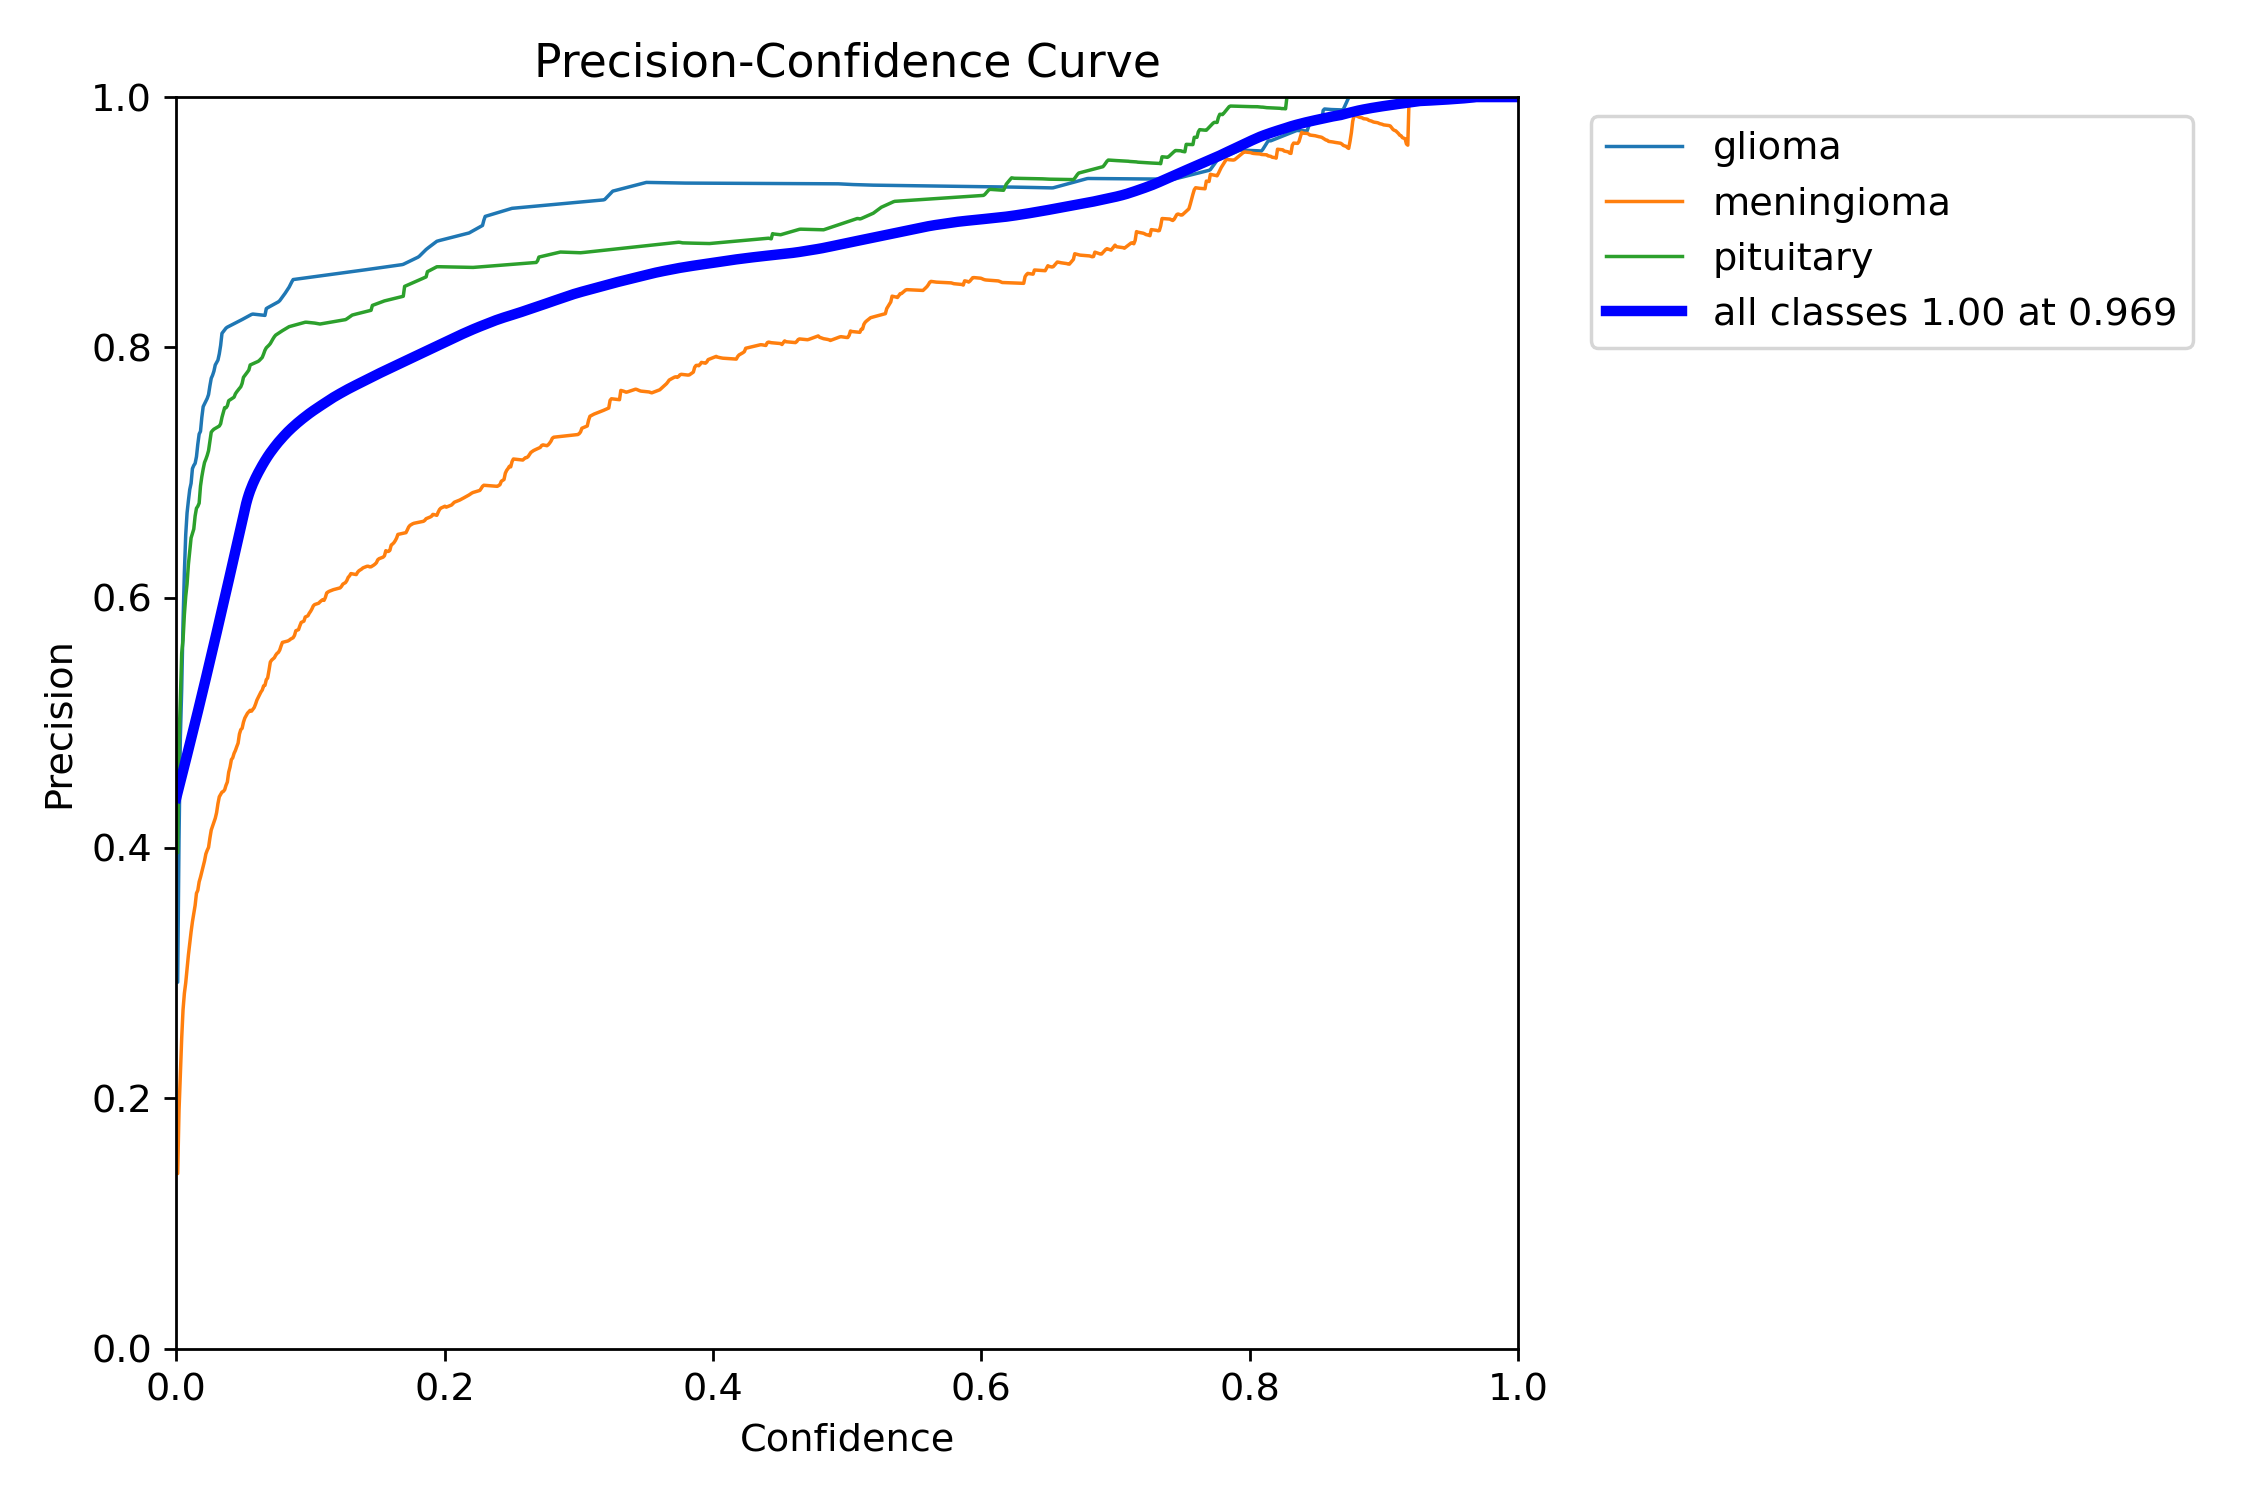

BoxR_curve.png


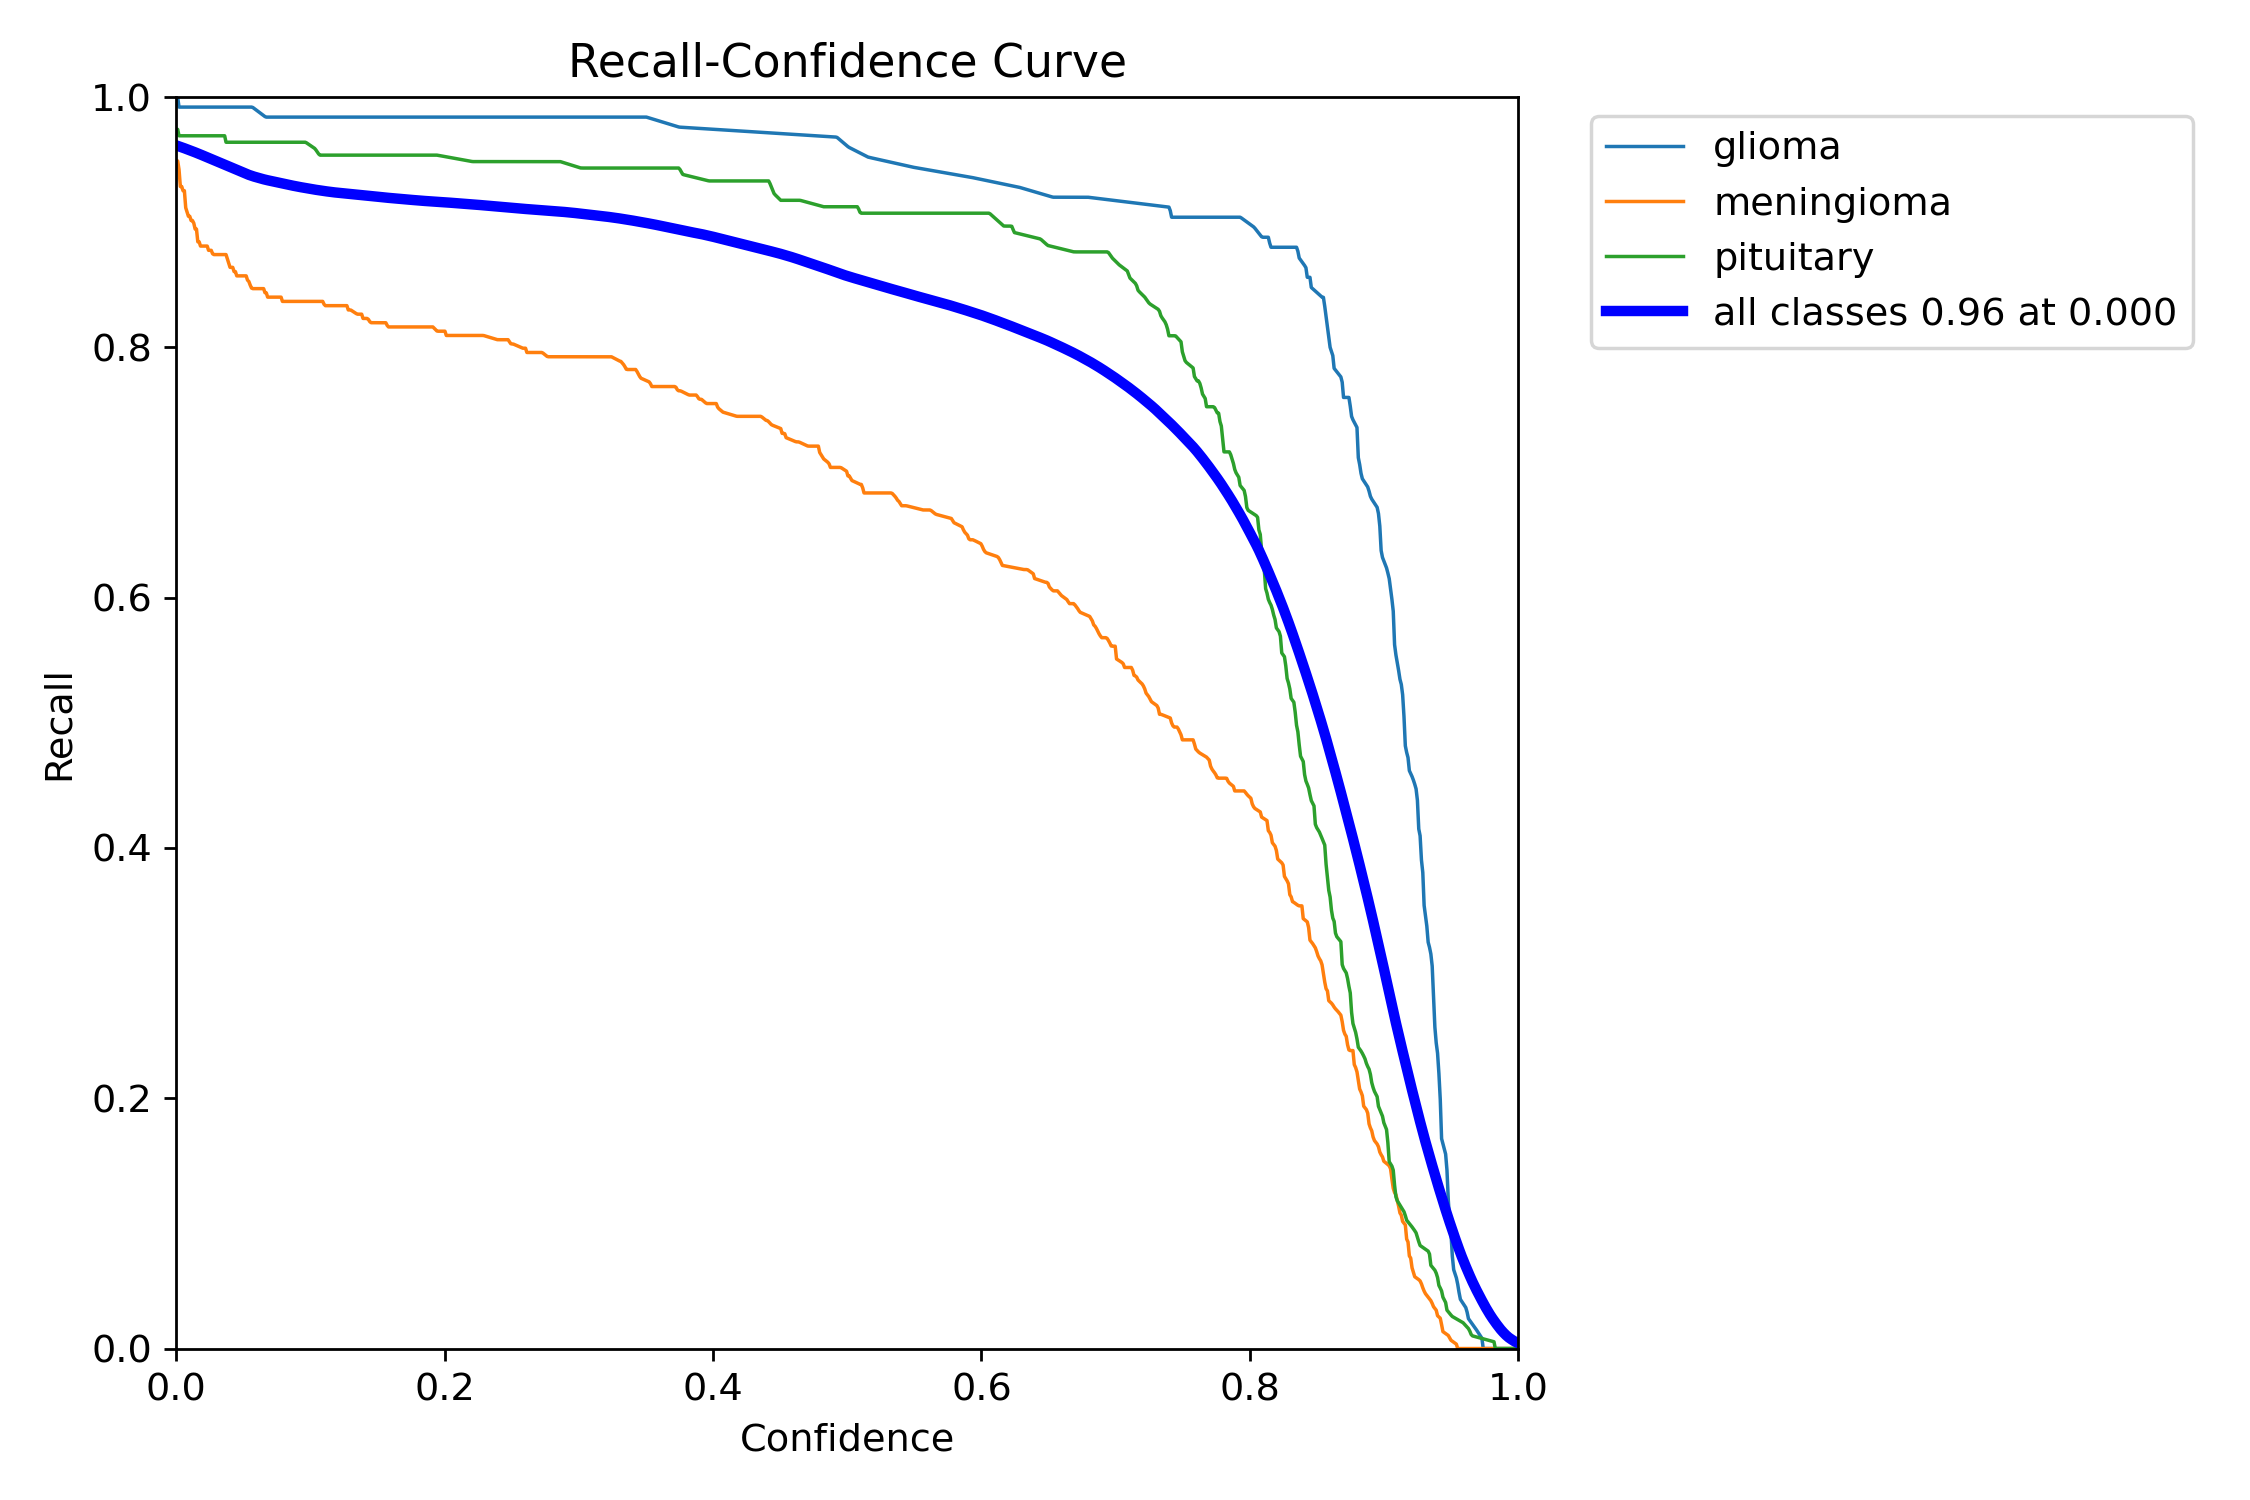

confusion_matrix.png


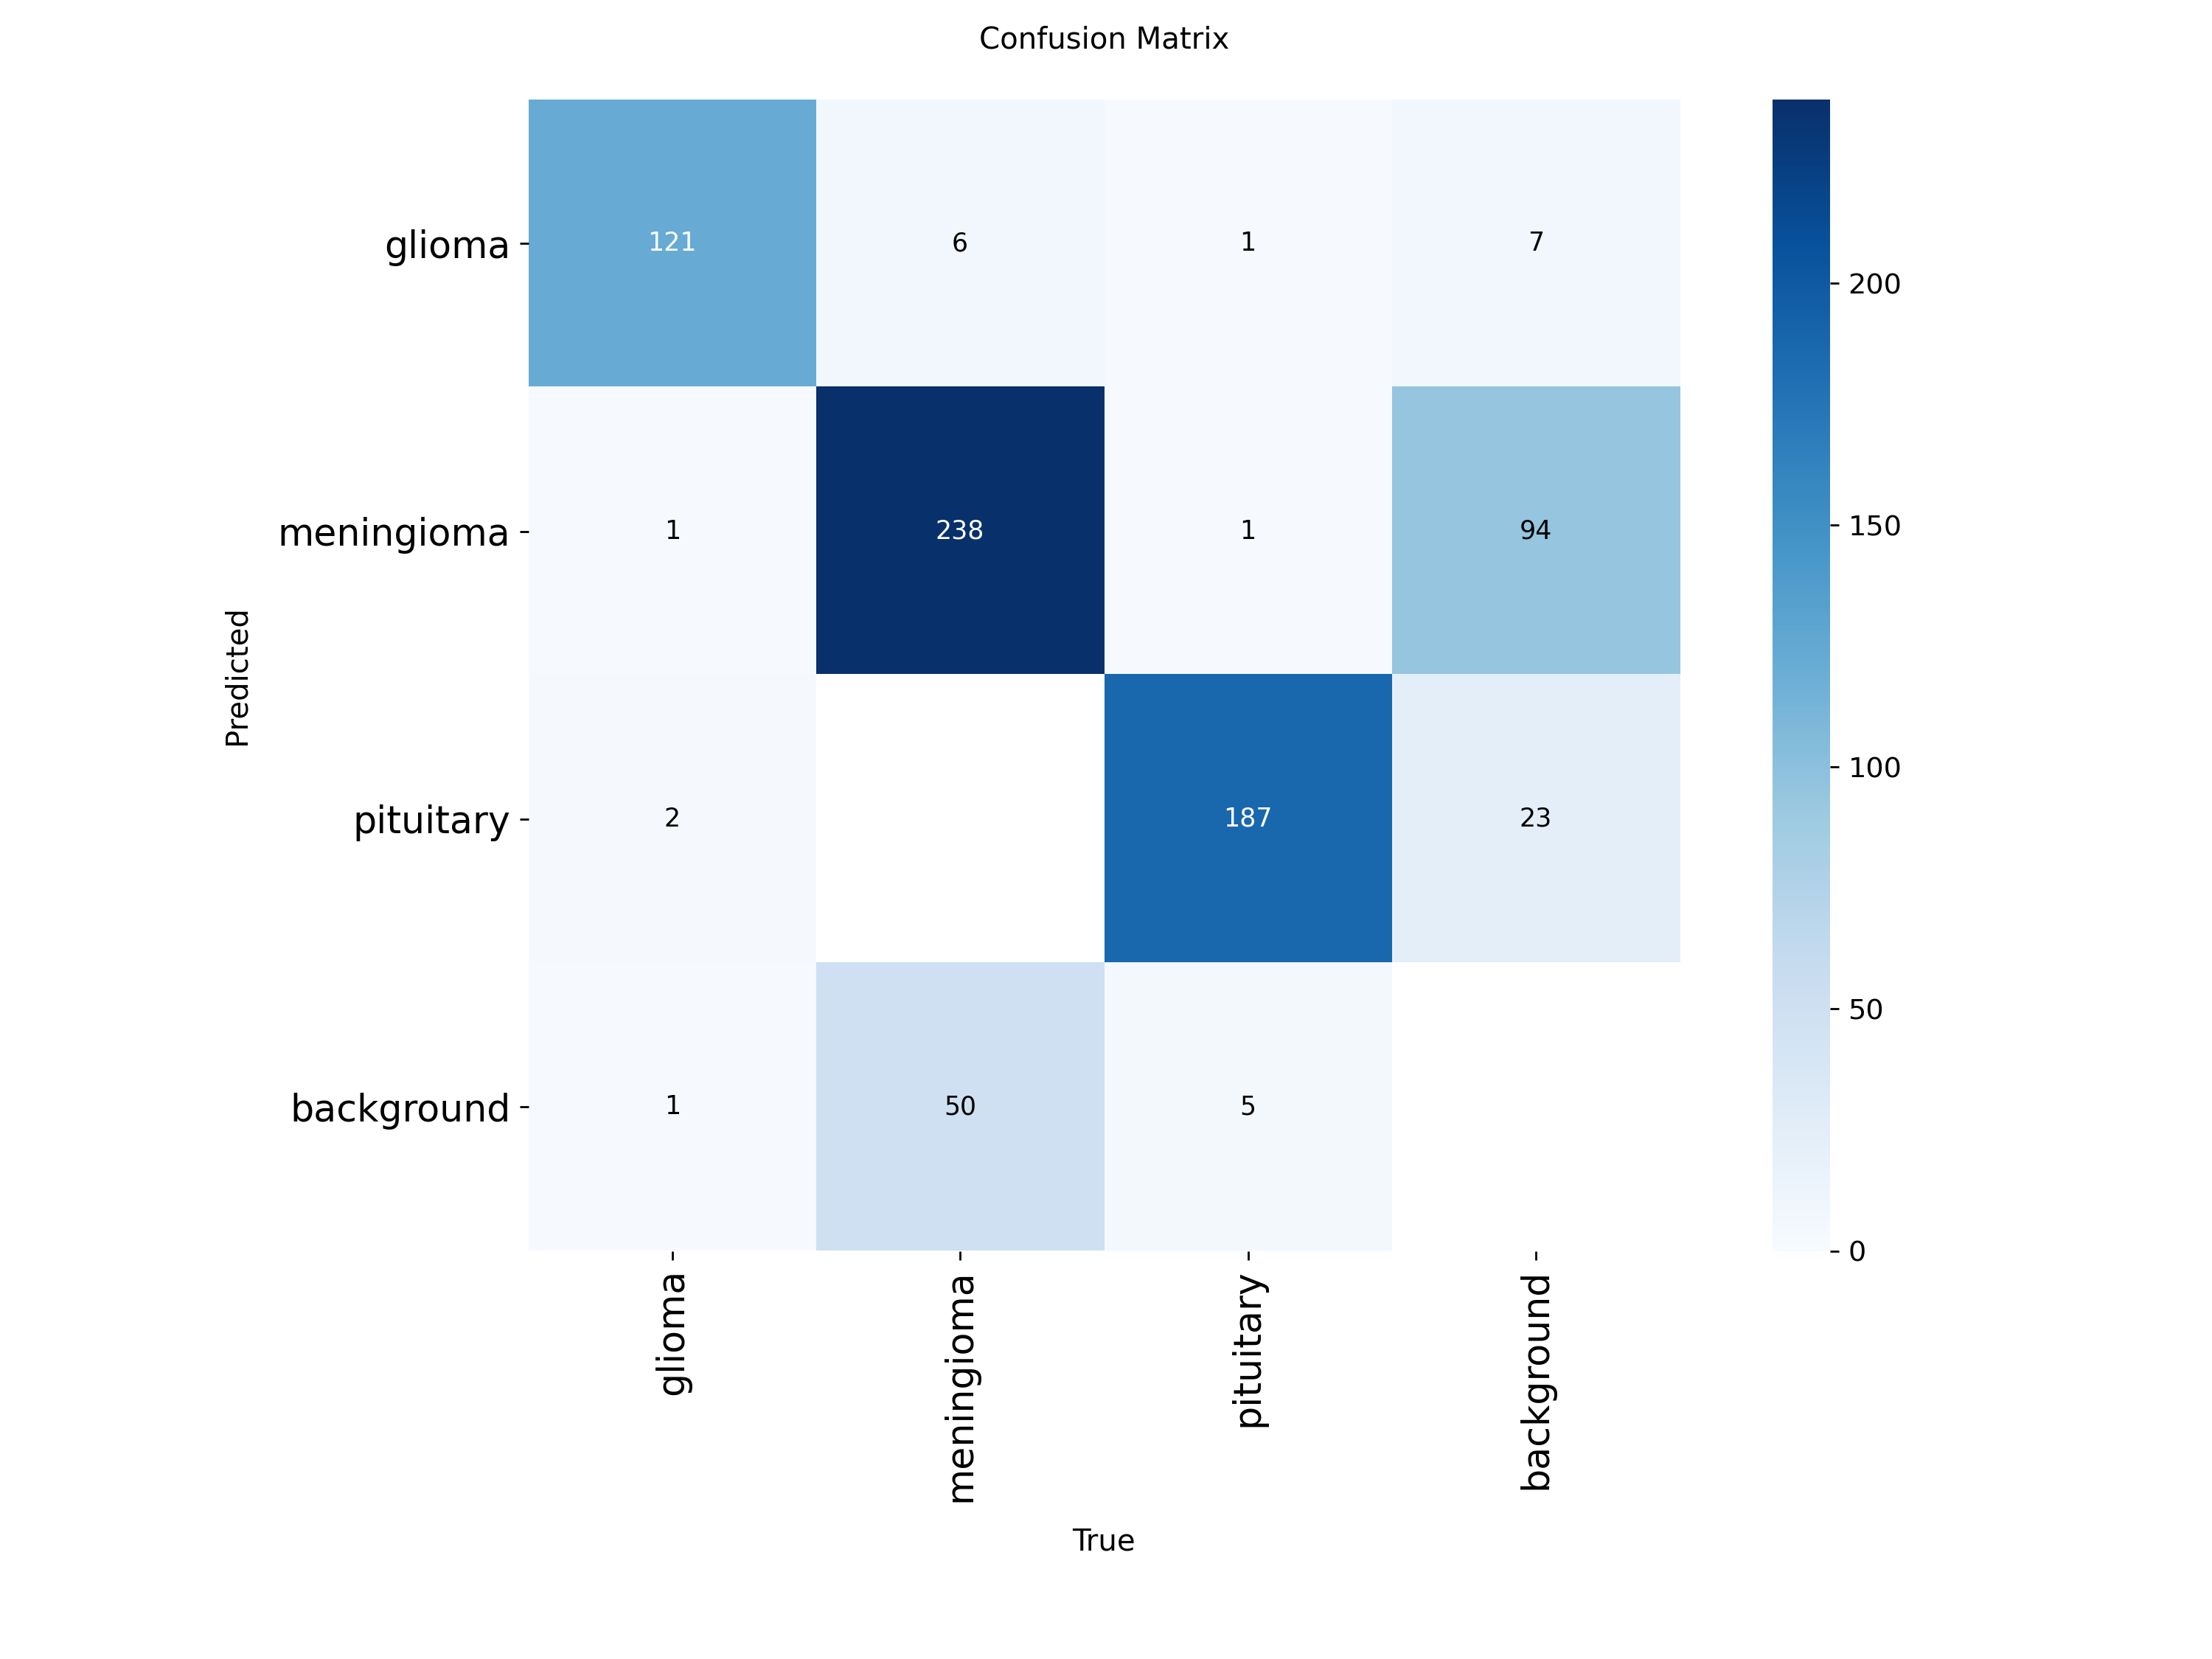

confusion_matrix_normalized.png


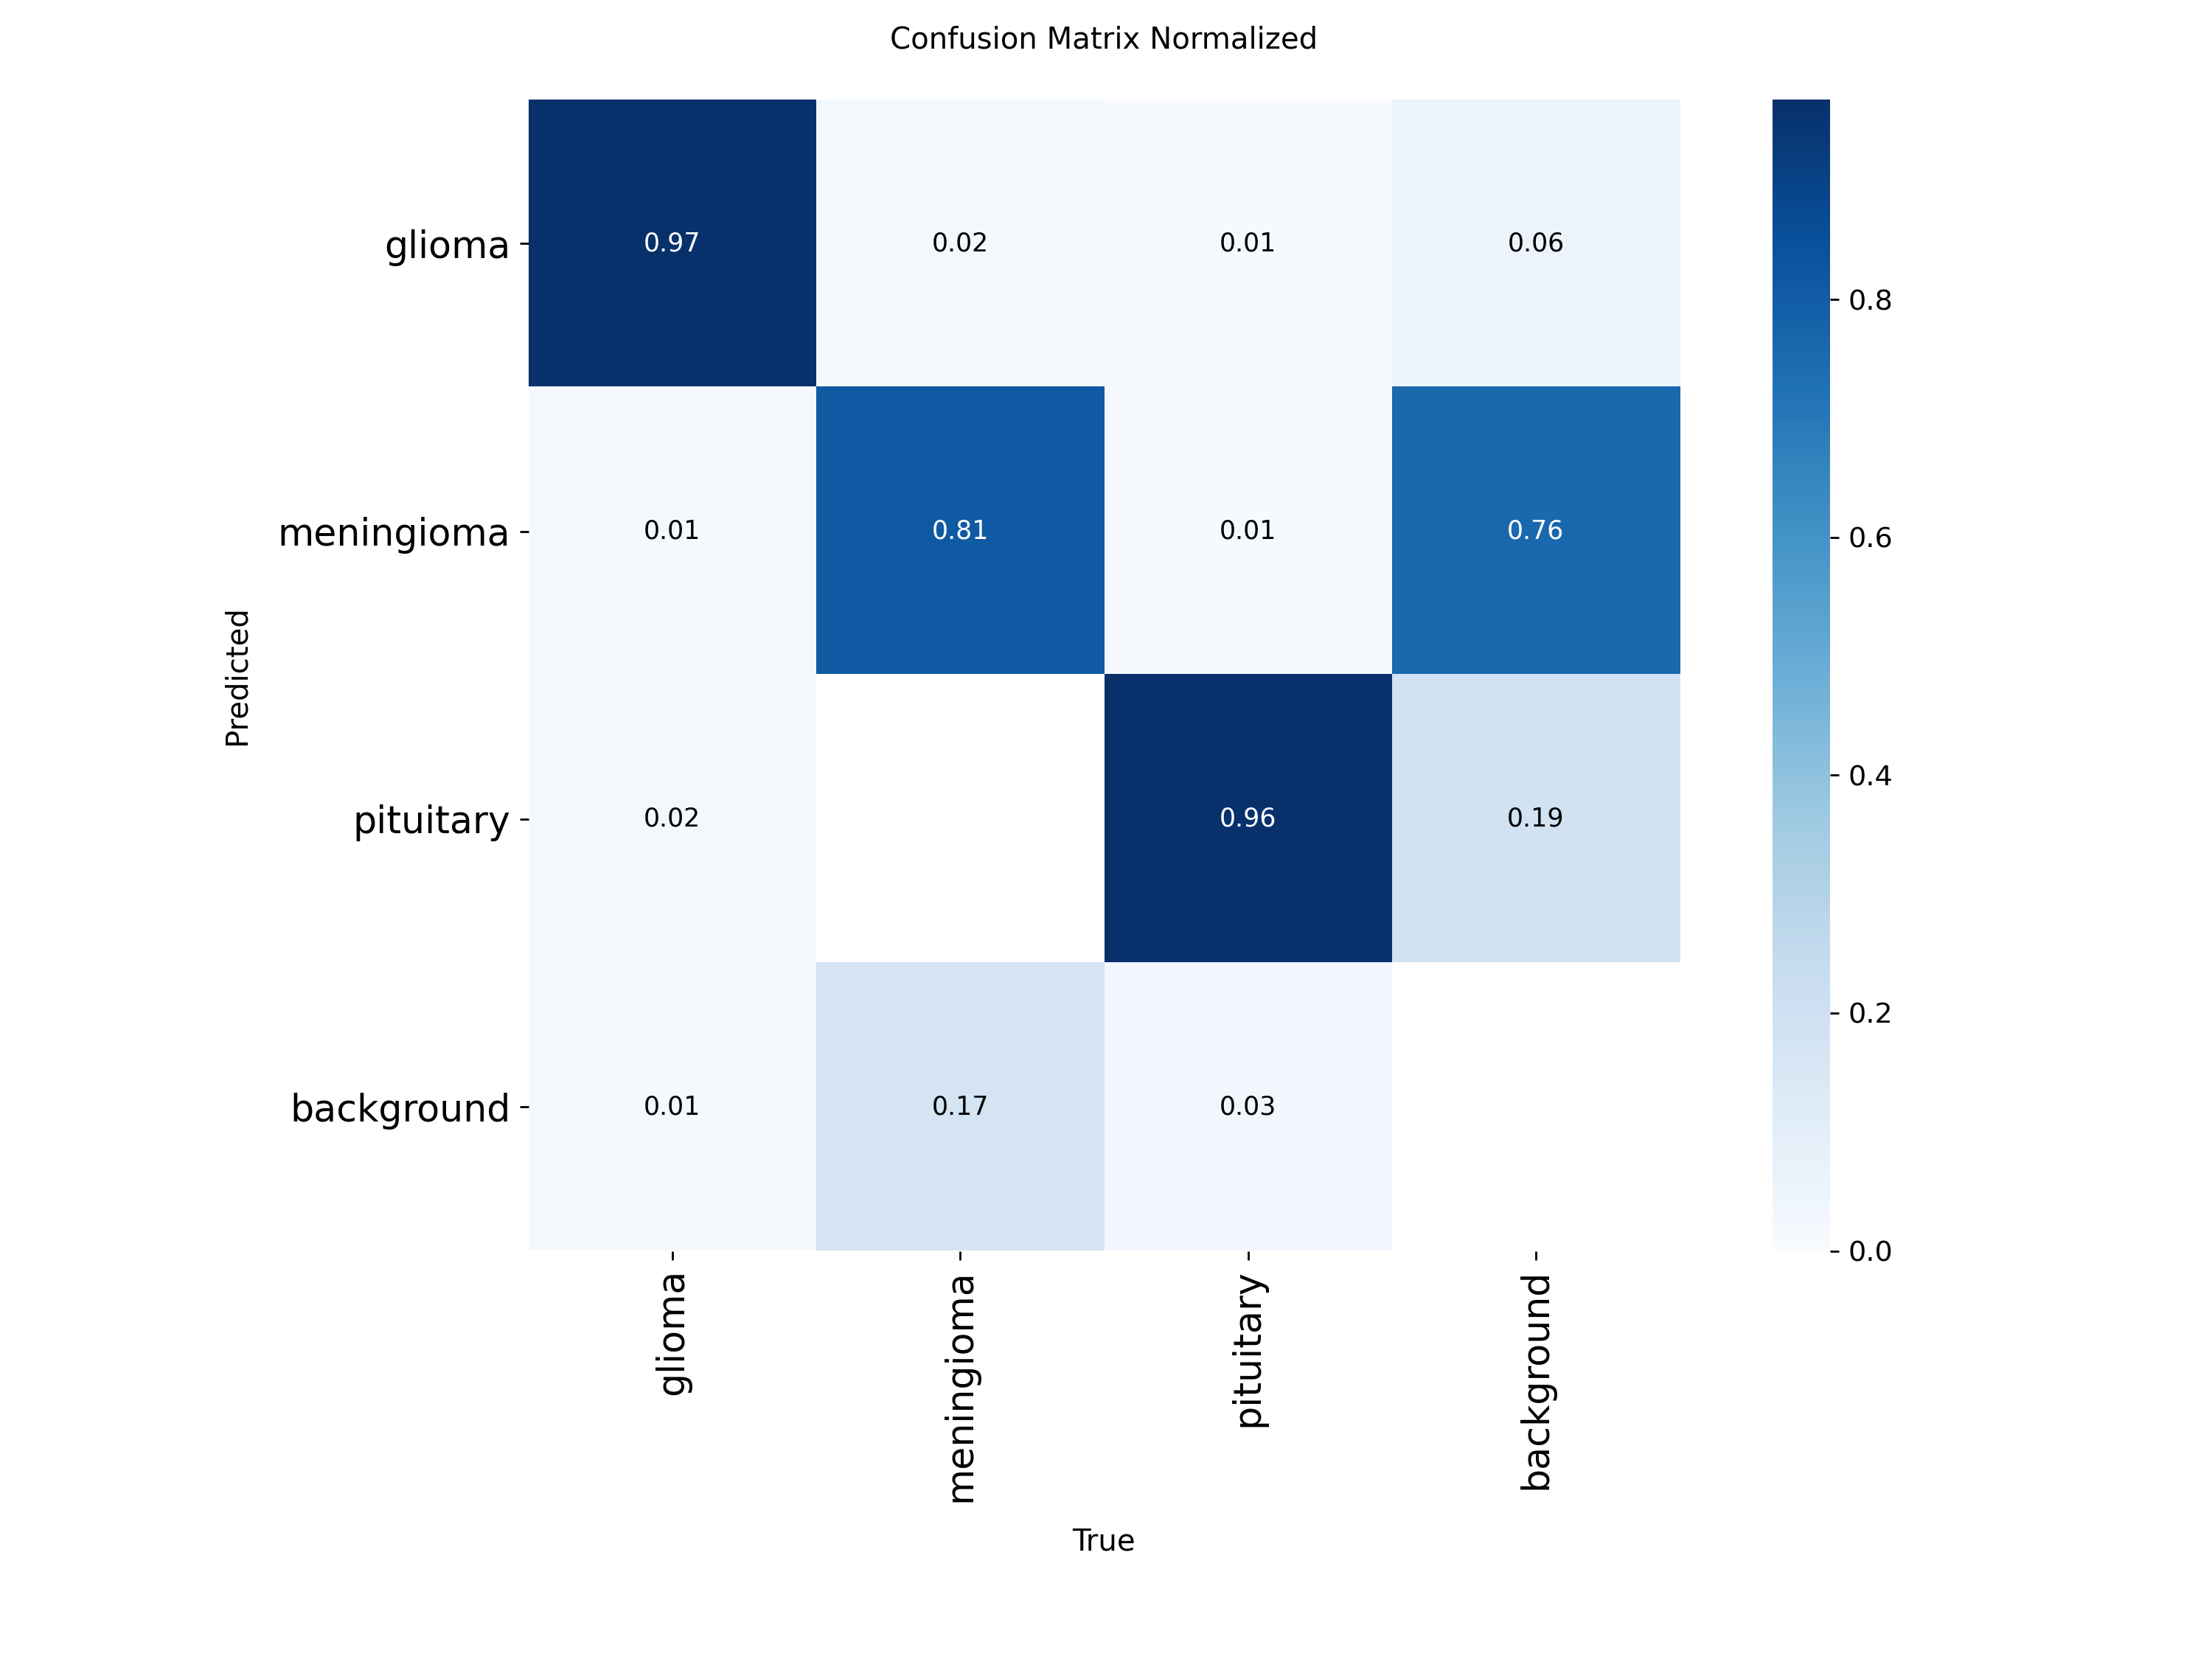

results.png


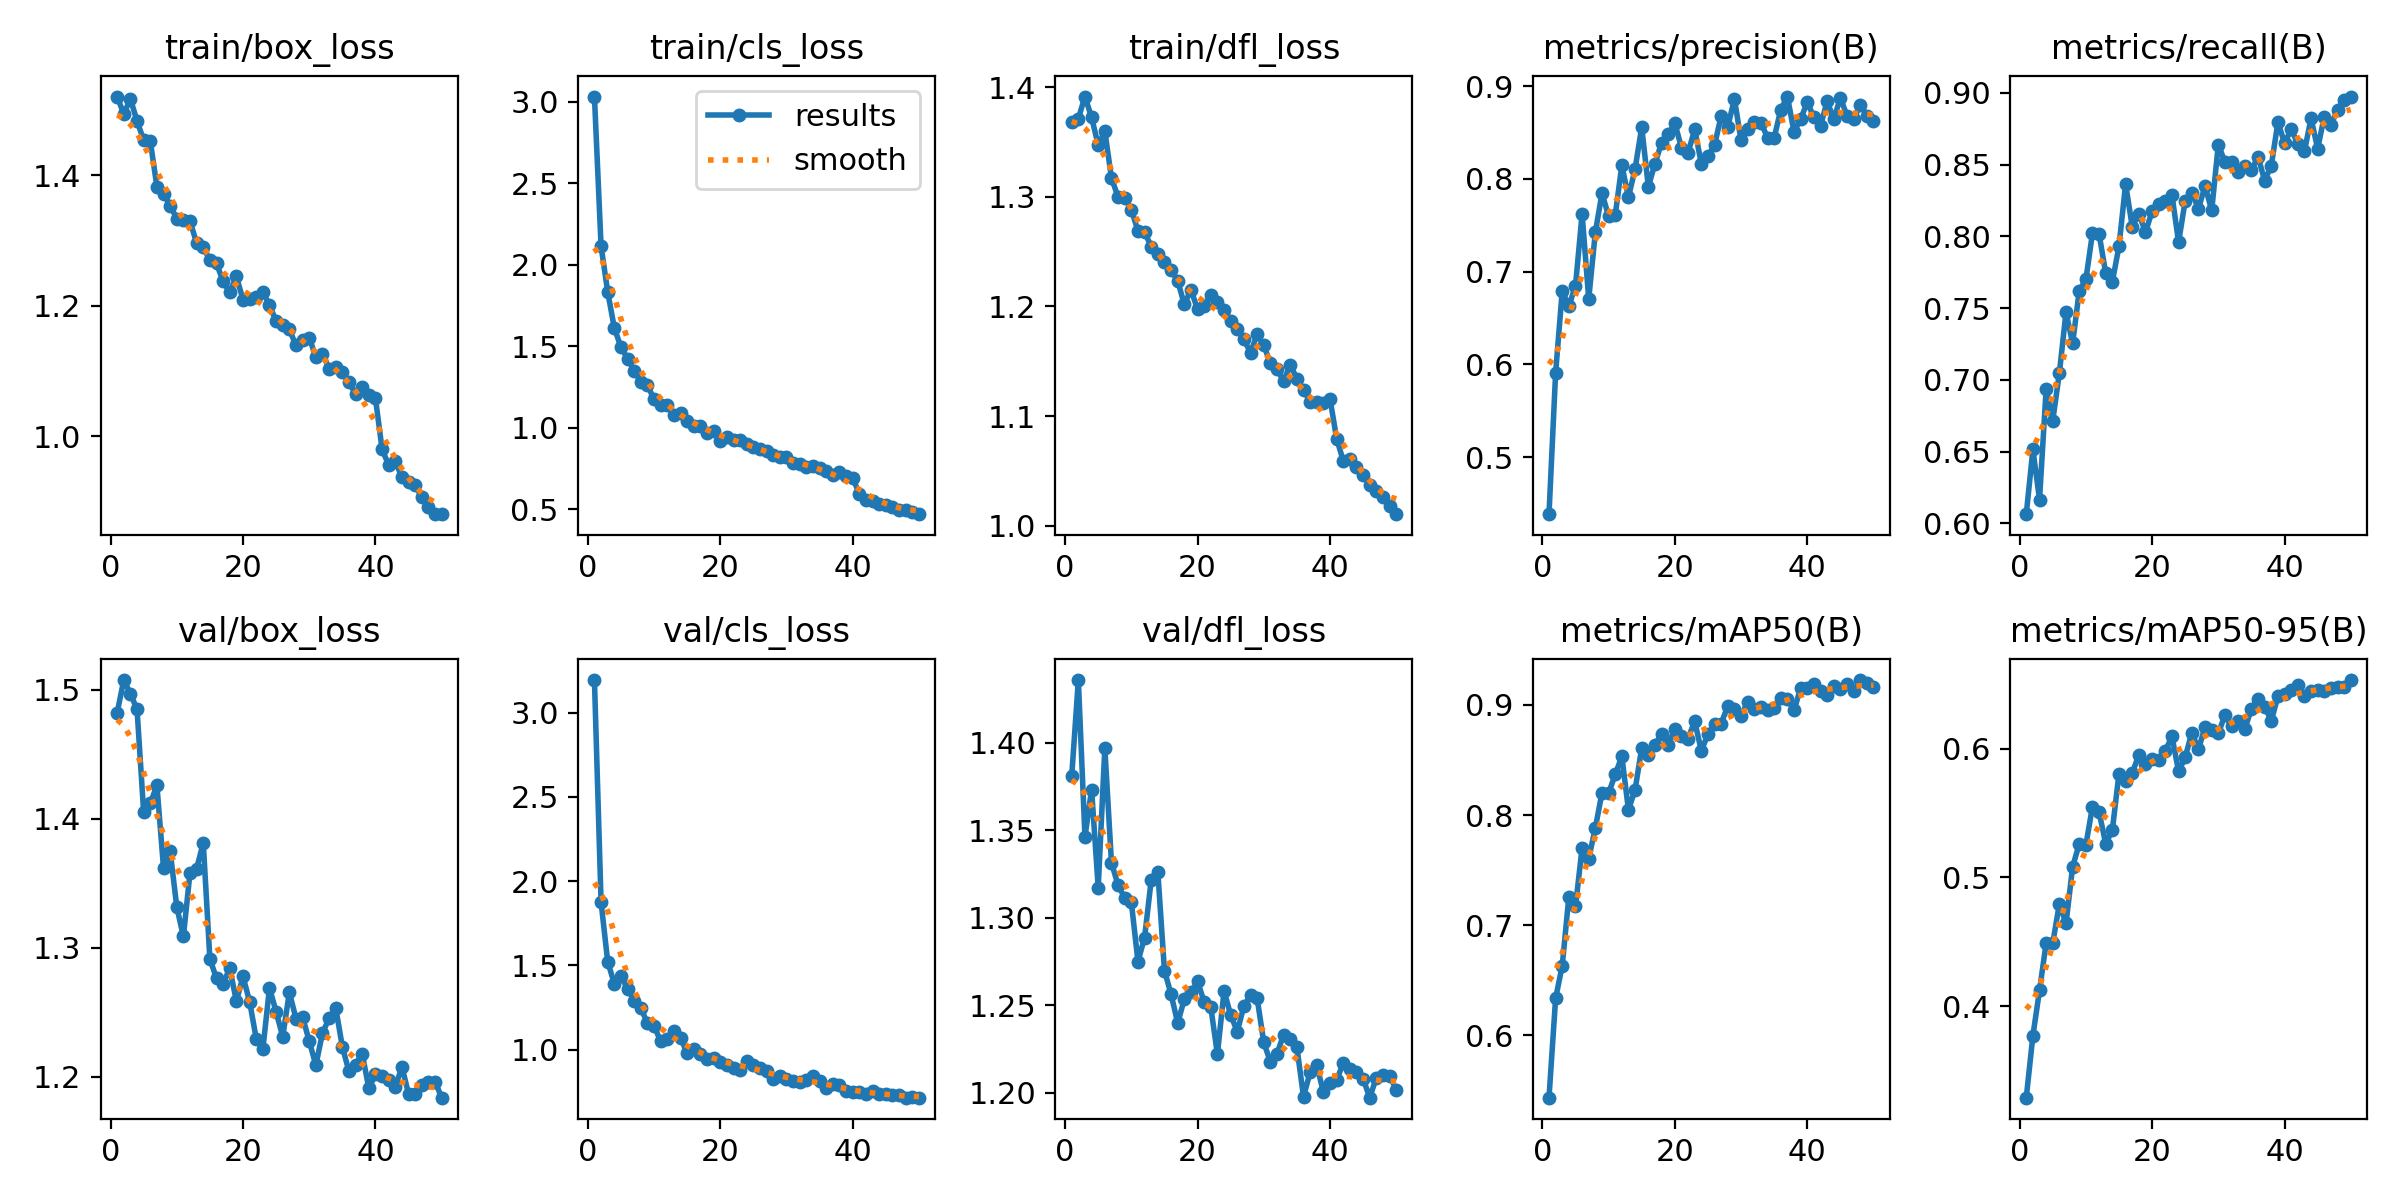

In [13]:
import glob
from IPython.display import Image, display

run_dir = "runs/detect/train"   # same as above

pngs = sorted(glob.glob(os.path.join(run_dir, "*.png")))
print(pngs)  # optional: see what files exist

for p in pngs:
    print(os.path.basename(p))
    display(Image(filename=p))


In [14]:
import glob

run_dir = "runs/detect/train"  # change if needed

all_plots = sorted(glob.glob(f"{run_dir}/*.png")) + sorted(glob.glob(f"{run_dir}/*.jpg"))

print("Found:", len(all_plots), "plots")
for p in all_plots:
    print(p)


Found: 20 plots
runs/detect/train/BoxF1_curve.png
runs/detect/train/BoxPR_curve.png
runs/detect/train/BoxP_curve.png
runs/detect/train/BoxR_curve.png
runs/detect/train/confusion_matrix.png
runs/detect/train/confusion_matrix_normalized.png
runs/detect/train/results.png
runs/detect/train/labels.jpg
runs/detect/train/train_batch0.jpg
runs/detect/train/train_batch1.jpg
runs/detect/train/train_batch12280.jpg
runs/detect/train/train_batch12281.jpg
runs/detect/train/train_batch12282.jpg
runs/detect/train/train_batch2.jpg
runs/detect/train/val_batch0_labels.jpg
runs/detect/train/val_batch0_pred.jpg
runs/detect/train/val_batch1_labels.jpg
runs/detect/train/val_batch1_pred.jpg
runs/detect/train/val_batch2_labels.jpg
runs/detect/train/val_batch2_pred.jpg


In [15]:
import os
import shutil

save_dir = "/content/yolo_plots_saved"
os.makedirs(save_dir, exist_ok=True)

for p in all_plots:
    shutil.copy(p, os.path.join(save_dir, os.path.basename(p)))

print("Saved all plots to:", save_dir)


Saved all plots to: /content/yolo_plots_saved


In [16]:
!zip -r yolo_all_plots.zip /content/yolo_plots_saved


  adding: content/yolo_plots_saved/ (stored 0%)
  adding: content/yolo_plots_saved/val_batch1_labels.jpg (deflated 23%)
  adding: content/yolo_plots_saved/BoxR_curve.png (deflated 10%)
  adding: content/yolo_plots_saved/train_batch12281.jpg (deflated 20%)
  adding: content/yolo_plots_saved/train_batch2.jpg (deflated 9%)
  adding: content/yolo_plots_saved/val_batch2_labels.jpg (deflated 16%)
  adding: content/yolo_plots_saved/val_batch1_pred.jpg (deflated 22%)
  adding: content/yolo_plots_saved/BoxPR_curve.png (deflated 13%)
  adding: content/yolo_plots_saved/confusion_matrix.png (deflated 29%)
  adding: content/yolo_plots_saved/confusion_matrix_normalized.png (deflated 25%)
  adding: content/yolo_plots_saved/train_batch1.jpg (deflated 10%)
  adding: content/yolo_plots_saved/labels.jpg (deflated 34%)
  adding: content/yolo_plots_saved/val_batch2_pred.jpg (deflated 16%)
  adding: content/yolo_plots_saved/val_batch0_labels.jpg (deflated 23%)
  adding: content/yolo_plots_saved/train_batch1

In [18]:
from google.colab import files
files.download("yolo_all_plots_multi.zip")


FileNotFoundError: Cannot find file: yolo_all_plots_multi.zip